In [ ]:
!pip install normalise
!pip install spacymoji
import numpy as np
import multiprocessing as mp
import pandas as pd
import string
import spacy
from sklearn.base import TransformerMixin, BaseEstimator
from spacymoji import Emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets
import datasets
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
df = dataset['train'].to_pandas()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df[['hatespeech', 'text']]

,hatespeech,text
0,0.0,Yes indeed. She sort of reminds me of the elde...
1,0.0,The trans women reading this tweet right now i...
2,2.0,Question: These 4 broads who criticize America...
3,0.0,It is about time for all illegals to go back t...
4,2.0,For starters bend over the one in pink and kic...
...,...,...
135551,0.0,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...
135552,0.0,Millions of #Yemen-is participated in mass ral...
135553,0.0,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
135554,0.0,Millions of #Yemen-is participated in mass ral...


In [ ]:
df["hatespeech"].value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

In [ ]:
df['hatespeech'] = (df['hatespeech']).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
df['hatespeech'] .value_counts(normalize=True)

0    0.594765
1    0.405235
Name: hatespeech, dtype: float64

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("emoji", first=True)

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Removing handles/usernames
            4. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        replace_emoji = self._replace_emoji(doc)
        doc = nlp(replace_emoji)

        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        removed_user_names = self._remove_user_names(removed_stop_words)
        removed_links = self._remove_links(removed_user_names)
        return self._lemmatize(removed_links)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _replace_emoji(self, doc):
        text = ''
        for t in doc:
            if t._.is_emoji:
                text += str(t._.emoji_desc) + ' '
            else:
                text +=  str(t) + ' '
        return text

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _remove_user_names(self, doc):
        return (t for t in doc if '@' not in t.text)

    def _remove_links(self,doc):
        return (t for t in doc if not t.like_url)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

In [ ]:
df['text_process'] = TextPreprocessor(n_jobs=-1).transform(df['text'][:1000])

In [ ]:
# Not lets move away from preprocessing our text data and actually start modeling

In [ ]:
def cross_validation_pip(X_train, y_train, estimator, num_split = 5):
  
  kf = KFold(n_splits= num_split)

  kf.get_n_splits(X_train)
  
  score_val_list = []
  score_train_list = []
  
  for train_index, test_index in kf.split(X):
      # print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      estimator.fit(X_train, y_train)

      # now how did we do?
      accuracy_train = estimator.score(X_train, y_train)
      accuracy_val = estimator.score(X_test, y_test)
      score_val_list.append(accuracy_val)
      score_train_list.append(accuracy_train)
    
  return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import normalize
from sklearn.model_selection import KFold

X = df["text_process"][:1000]
y = df['hatespeech'][:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= .3, stratify= y)

clf  = Pipeline(steps=[ 
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', LogisticRegression(solver='saga', n_jobs=-1))
    ])

clf.fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
clf1_score = cross_validation_pip(X_train, y_train, clf, num_split = 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


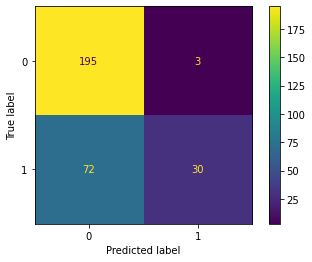

In [ ]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)

That was the result of our first model, a logistic regression model aimed to calssify hatespeech and not hatespeech. Lets see if a more complicated model can do better!

In [ ]:
clf2  = Pipeline(steps=[
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', MultinomialNB(alpha=1.0, fit_prior=True))])

clf2.fit(X_train, y_train)

y_pred_NB = clf2.predict(X_test)

clf2_score = clf2.score(X_test, y_test)



In [ ]:
clf2_cross_val_score = cross_validation_pip(X_train, y_train, clf2, num_split = 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


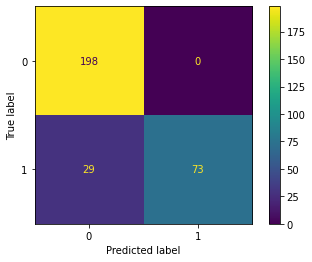

In [ ]:
plot_confusion_matrix(clf2, X_test, y_test)

In [ ]:
from sklearn.svm import LinearSVC

clf3  = Pipeline(steps=[
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', LinearSVC(random_state=0, tol=1e-5) )] )

clf3.fit(X_train, y_train)

y_pred_SVM = clf3.predict(X_test)

clf3_score = clf3.score(X_test, y_test)



In [ ]:
clf3_cross_val_score = cross_validation_pip(X_train, y_train, clf3, num_split = 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


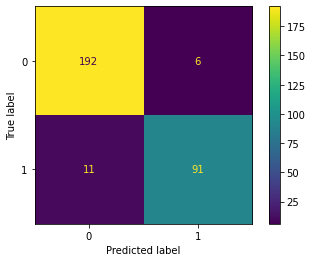

In [ ]:
plot_confusion_matrix(clf3, X_test, y_test)

In [ ]:
print(f"Logisitc Regression accuracy score {clf1_score} \nMultiNomialNB accuracy score {clf2_score} \nSVM score is {clf3_score}")

Logisitc Regression accuracy score {'train': 0.764, 'validation': 0.683} 
MultiNomialNB accuracy score 0.67 
SVM score is 0.6966666666666667


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Hate-Speech', 'Not Hate-Speech']
classification_report_dict = {}
for model, y_pred in zip(['LogisticRegressionCV', 'MultiNomialNB', 'LinearSVM'], [y_pred_log, y_pred_NB, y_pred_SVM]):
  classification_report_dict[model] = classification_report(y_test, y_pred, target_names=target_names)
  print(model, "\n", classification_report_dict[model])

LogisticRegressionCV 
                  precision    recall  f1-score   support

    Hate-Speech       0.68      0.96      0.80       198
Not Hate-Speech       0.64      0.14      0.23       102

       accuracy                           0.68       300
      macro avg       0.66      0.55      0.51       300
   weighted avg       0.67      0.68      0.60       300

MultiNomialNB 
                  precision    recall  f1-score   support

    Hate-Speech       0.67      0.99      0.80       198
Not Hate-Speech       0.71      0.05      0.09       102

       accuracy                           0.67       300
      macro avg       0.69      0.52      0.45       300
   weighted avg       0.68      0.67      0.56       300

LinearSVM 
                  precision    recall  f1-score   support

    Hate-Speech       0.73      0.86      0.79       198
Not Hate-Speech       0.58      0.38      0.46       102

       accuracy                           0.70       300
      macro avg       0.66   

In [ ]:
# import pickle

# filename = 'logisticRegression_model.sav'
# pickle.dump(clf, open(filename, 'wb'))

# filename2 = 'NB_model.sav'
# pickle.dump(clf2, open(filename2, 'wb'))

# filename3 = 'linearSVM_model.sav'
# pickle.dump(clf3, open(filename3, 'wb'))

In [ ]:
#%%
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}
#%%
def clean_text(text, remove_stopwords = False):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # removing non-ascii characters
    new_val = text.encode("ascii", "ignore")
    text = new_val.decode()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # lets try to do the same thing but now with slang words!
    

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # removes website links
    text = re.sub(r'\<a href', ' ', text) # removed HTML tags
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:$\[\]/]', ' ', text) # remove special characters
    text = re.sub(r'<br />', ' ', text) # removes html tags
    text = re.sub(r'\'', ' ', text) # removes backslash character

    text = re.sub("@[A-Za-z0-9_]+","", text) # removing handles
    text = re.sub("#[A-Za-z0-9_]+","", text) # removing hashtags

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english")) # pulling a list of stopwords from NLTK
        text = [w for w in text if not w in stops] # removing stopwords
        text = " ".join(text) # joing text list from previous step into a string

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text) #using NLKT word tokenizer
    text = " ".join(text) # finally joing tokens into one cleaned string

    return text
#%%

df["text_cleaned"] = df["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

df["text_cleaned"]

0         yes indeed she sort of reminds me of the elder...
1         the trans women reading this tweet right now i...
2         question these 4 broads who criticize america ...
3         it is about time for all illegals to go back t...
4         for starters bend over the one in pink and kic...
                                ...                        
135551    # # news sayyed abdulmalik the saudi regime sh...
135552    millions of is participated in mass rallies on...
135553    dictator goes this is the people of iran who a...
135554    millions of is participated in mass rallies on...
135555    op i really hope that you commit suicide one d...
Name: text_cleaned, Length: 135556, dtype: object

### Lets try using our NLTK preprocessor and train our model with a cleaned corpus and TFID corpus transformer! 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import normalize
from sklearn.model_selection import KFold

A = df["text_cleaned"][:1000]
b = df['hatespeech'][:1000]

A_train, A_test, b_train, b_test = train_test_split(A, b, random_state= 42, test_size= .3, stratify= b)

pipe1  = Pipeline(steps=[
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', LogisticRegression(solver='saga', n_jobs=-1))
    ])

pipe1.fit(A_train, b_train)
y_pred_log_nltk = pipe1.predict(A_test)
pipe1_score = cross_validation_pip(A_train, b_train, pipe1, num_split = 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


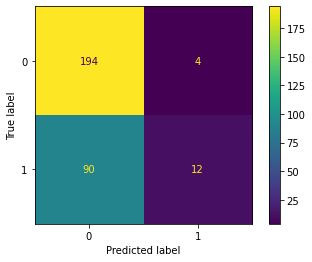

In [ ]:
plot_confusion_matrix(pipe1, A_test, b_test)

In [ ]:
pipe2  = Pipeline(steps=[
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', MultinomialNB(alpha=1.0, fit_prior=True))])

pipe2.fit(A_train, b_train)

y_pred_NB_nltk = pipe2.predict(A_test)

pipe2_score = pipe2.score(A_test, b_test)



In [ ]:
pipe2_cross_val_score = cross_validation_pip(A_train, b_train, pipe2, num_split = 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


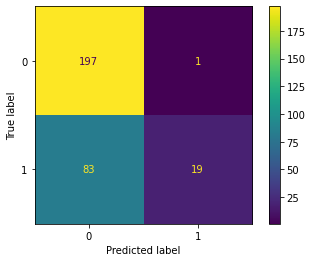

In [ ]:
plot_confusion_matrix(pipe2, A_test, b_test)

In [ ]:
from sklearn.svm import LinearSVC

best_est  = Pipeline(steps=[
    ('features', TfidfVectorizer(ngram_range = (1,2), sublinear_tf=True)),
    ('classifier', LinearSVC(C=0.1, max_iter=5000, random_state=0, tol= 1e-4))
    ]) 

# best_est.fit(A_train, b_train)

# y_pred_SVM_ntlk = pipe3.predict(A_test)

# pipe3_score = pipe3.score(A_test, b_test)



In [ ]:
# pipe3_cross_val_score = cross_validation_pip(A_train, b_train, pipe3, num_split = 5)

In [ ]:
# plot_confusion_matrix(pipe3, A_test, b_test)

In [ ]:
#print(f"Logisitc Regression accuracy score {pipe1_score} \nMultiNomialNB accuracy score {pipe2_score} \nSVM score is {pipe3_score}")

Now that we know that SVM works the best and that the NLTK prepocessed data tends to give us a better score, its time to hyper parameter tune our classifier!

In [ ]:
X = df["text_cleaned"]
y = df['hatespeech']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= .3, stratify= y)

In [ ]:
# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],
#               'classifier__tol': [1e-5, 1e-4, 1e-2, 1e0, 1e2],
#                 'features__max_df': (0.25, 0.5, 0.75),
#                 'features__ngram_range': [(1, 1), (1, 2), (1, 3)]} 

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)} 

# gs_pipe = GridSearchCV(pipe3, param_grid, scoring= scoring, refit="AUC", verbose = 3)

# gs_pipe.fit(X_train, y_train)

# best_est = gs_pipe.best_estimator_

In [ ]:
# results = gs_pipe.cv_results_

In [ ]:
# best_est.get_params

In [ ]:
# best_est

In [ ]:
best_est.fit(X_train, y_train)

y_pred_best= best_est.predict(X_test)

y_proba = best_est.decision_function(X_test)


best_est_score = best_est.score(X_test, y_test)

In [ ]:
print(f"Accuracy score for nltk transformed model with grid search parameter-tuning is {best_est_score}")

Accuracy score for nltk transformed model with grid search parameter-tuning is 0.8067474856763469


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


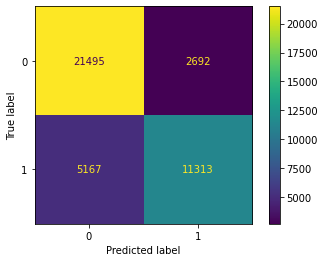

In [ ]:
plot_confusion_matrix(best_est, X_test, y_test)

In [ ]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     24187
           1       0.81      0.69      0.74     16480

    accuracy                           0.81     40667
   macro avg       0.81      0.79      0.79     40667
weighted avg       0.81      0.81      0.80     40667



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


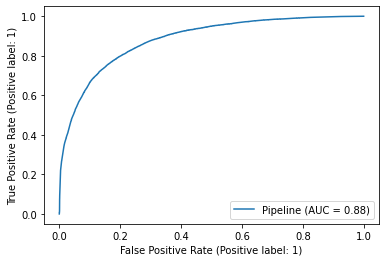

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(best_est, X_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_proba)

0.8821769477385147

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# rgs_cv  = RandomizedSearchCV(pipe3, param_grid, scoring= scoring, refit="AUC", verbose = 3, cv = 3)

# rgs_cv.fit(X_train, y_train)

# best_est = rgs_cv.best_estimator_

In [ ]:
# best_est.get_params

Lets try a randomized grid search on our entire dataset instead of a subsection of it.

In [ ]:
# import pickle

# filename = 'logisticRegression_model_nltk.sav'
# pickle.dump(pipe1, open(filename, 'wb'))

# filename2 = 'NB_model_nltk.sav'
# pickle.dump(pipe2, open(filename2, 'wb'))

# filename3 = 'linearSVM_model_nltk.sav'
# pickle.dump(pipe3, open(filename3, 'wb'))

In [ ]:
df["text_cleaned"][6]

'who the fuck is this insignificant simple minded redneck when he gets a vagina he can decide what he wants to do with it'